In [1]:
import pickle
from pathlib import Path
import numpy as np
import sys

ws_dir = Path('..')

if sys.platform.lower()=='linux':
    datadir = Path('/scratch/users/ianpg/SWIlarge/data')
    workdir = Path('/scratch/users/ianpg/SWIlarge/work')
    MPSdir = datadir.joinpath('lith/sgems/MPS')
    lithdir = datadir.joinpath('lith/sgems/')
    GISdir = datadir.joinpath('GIS')
    priordir = datadir.joinpath('PriorModel')
    modeldir = datadir.joinpath('NM_model')
elif sys.platform.lower()=='darwin':
    lithdir = ws_dir.joinpath('data','lith','sgems')


def load_obj(dirname, name):
    import pickle
    with open(Path(dirname).joinpath(name + '.pkl').as_posix(), 'rb') as f:
        return pickle.load(f)


def save_obj(dirname, obj, name):
    import pickle
    with open(Path(dirname).joinpath(name + '.pkl').as_posix(), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


In [2]:
outputdir_sisim = lithdir.joinpath('sisim')
outputdir_snesim = lithdir.joinpath('snesim')


In [ ]:
outputdir_sisim = lithdir.joinpath('sisim')
if not outputdir_sisim.exists():
    outputdir_sisim.mkdir(parents=True)
outputdir_snesim = lithdir.joinpath('snesim')
if not outputdir_snesim.exists():
    outputdir_snesim.mkdir(parents=True)
    
varlist = load_obj(ws_dir.joinpath('data/PriorModel'), 'varlist')
n_it = len(varlist[[k for k,v in varlist.items()][0]])
# TI_prop_values = np.array([45 ,55 ,65 ,75])
# TI_props = TI_prop_values[varlist['TI_prop']].astype(int)
# varlist['TI_props']=TI_props

In [6]:
[k for k,v in varlist.items()]

['kvh',
 'por_sand',
 'por_clay',
 'aL',
 'TI_wavelength',
 'TI_amplitude',
 'TI_width',
 'TI_direction',
 'TI_prop',
 'kh_sand_180',
 'kh_clay_180',
 'DSA_head',
 'TSW_head',
 'r_x',
 'r_y',
 'r_z',
 'prop_400',
 'sill',
 'kh_sand_400',
 'kh_clay_400',
 'kh_lay1',
 'thinning',
 'n_conduits',
 'RP_model',
 'm',
 'CF_cp',
 'CF_cr',
 'seed',
 'TI_props']

In [202]:
def write_run_save_snesim(name,varlist,it):  
    cmd_run = ('RunGeostatAlgorithm  snesim_std::/GeostatParamUtils/XML::<parameters>  '
           '<algorithm name="snesim_std" />     '
           '<Use_Affinity  value="0"  />     <Use_Rotation  value="0"  />     '
           '<Cmin  value="1" />     <Constraint_Marginal_ADVANCED  value="0" />     '
           '<resimulation_criterion  value="-1" />     <resimulation_iteration_nb  value="1" />     <Nb_Multigrids_ADVANCED  value="5" />     '
           '<Debug_Level  value="0" />     <Subgrid_choice  value="0"  />     '
           '<expand_isotropic  value="1"  />     <expand_anisotropic  value="0"  />     '
           '<aniso_factor  value="        " />     <Hard_Data  grid="lith_bin_rot" region="" property="Lith_binary"  />     '
           '<use_pre_simulated_gridded_data  value="0"  />     <Use_ProbField  value="0"  />     '
           '<ProbField_properties count="0"   value=""  />     '
           '<TauModelObject  value="1 1" />     <use_vertical_proportion  value="0"  />     '
           '<GridSelector_Sim value="swi_large_grid_2" region=""  />     '
           '<Property_Name_Sim  value="{name}_{it}" />     <Nb_Realizations  value="1" />     '
           '<Seed  value="{seed}" />     '
           '<PropertySelector_Training  grid="swi_grid_small2" region="" property="{ti_name}"  />     '
           '<Nb_Facies  value="2" />     '
           '<Marginal_Cdf  value="0.33 0.67" />     <Max_Cond  value="30" />     '
           '<Search_Ellipsoid  value="4000 2000 20  90 0 0" />  </parameters>   '.format(
               it=it,
               name=name,
               seed=varlist['seed'][it] + 1, #ones-based
               ti_name='ti_' + str(varlist['TI_props'][it])
           ))
    cmd_save = 'SaveGeostatGrid  swi_large_grid_2::C:/Users/ianpg/Documents/git/SWIlarge/data/lith/sgems/snesim/{name}_{it}.gslib::gslib::0::{name}_{it}__real0'.format(name=name,it=it)
    return cmd_run,cmd_save


def write_run_save_sisim(name,varlist,it):  
    cmd_run = ('RunGeostatAlgorithm  sisim::/GeostatParamUtils/XML::<parameters>  <algorithm name="sisim" />     '
           '<Hard_Data_Grid value="lith_bin_rot" region=""  />     '
           '<Hard_Data_Property  value="Lith_binary"  />     <Assign_Hard_Data  value="1"  />     '
           '<coded_grid value="" region=""  />     <coded_props count="0"   value=""  />     '
           '<Max_Conditioning_Data  value="30" />     <Search_Ellipsoid  value="1000 500 25  90 0 0" />    '
           '<AdvancedSearch  use_advanced_search="0"></AdvancedSearch>    '
           '<Variogram_Median_Ik  nugget="0" structures_count="1"  >    <structure_1  contribution="1"  type="Spherical"   >      '
           '<ranges max="{r_x}"  medium="{r_y}"  min="{r_z}"   />      '
           '<angles x="90"  y="0"  z="0"   />    </structure_1>  </Variogram_Median_Ik>    <Grid_Name value="swi_large_grid_2" region=""  />     '
           '<Property_Name  value="{name}_{it}" />     '
           '<Nb_Realizations  value="1" />     <Seed  value="{seed}" />     <Categorical_Variable_Flag  value="1"  />     '
           '<Nb_Indicators  value="2" />     '
           '<Marginal_Probabilities  value="{prop_comp} {prop}" />     <lowerTailCdf  function ="Power"  extreme ="0"  omega ="3" />    '
           '<upperTailCdf  function ="Power"  extreme ="0"  omega ="0.333" />    '
           '<Median_Ik_Flag  value="1"  />     <Full_Ik_Flag  value="0"  />   </parameters>   '.format(
           r_x=varlist['r_x'][it],
           r_y=varlist['r_y'][it],
           r_z=varlist['r_z'][it],
           sill=varlist['sill'][it],
           seed=varlist['seed'][it],
           prop=round(varlist['prop_400'][it],2), 
           prop_comp= round(1-varlist['prop_400'][it],2), 
           name=name,
           it=it
           ))

    cmd_save = 'SaveGeostatGrid  swi_large_grid_2::C:/Users/ianpg/Documents/git/SWIlarge/data/lith/sgems/sisim/{name}_{it}.gslib::gslib::0::{name}_{it}__real0'.format(name=name,it=it)
    return cmd_run,cmd_save

### SISIM

In [208]:
its = np.arange(73,500)
name = 'sisim400'
fname_commands = outputdir_sisim.joinpath('{name}_{it1}_{it2}_commands.txt'.format(name=name,it1=its[0],it2=its[-1])).as_posix()

with open(fname_commands, 'w') as f:
    f.write('LoadProject  C:/Users/ianpg/Dropbox/temp_convenience/SWIlarge/data/lith/sgems/MPS/mps_180.prj \n')
    for it in its:
        if it%10==0:
            f.write('DeleteObjects  lith_bin_rot::swi_grid_large::swi_grid_small2::swi_large_grid_2 \n')
            f.write('LoadProject  C:/Users/ianpg/Dropbox/temp_convenience/SWIlarge/data/lith/sgems/MPS/mps_180.prj \n')
        cmd_run,cmd_save = write_run_save_sisim(name,varlist,it)
        f.write(cmd_run + ' \n')
        f.write(cmd_save + ' \n')
# call(['sgems-x64', fname_commands], shell=False)

### SNESIM

In [209]:
its = np.arange(22,500)
name = 'mps180'
fname_commands = outputdir_snesim.joinpath('{name}_{it1}_{it2}_commands.txt'.format(name=name,it1=its[0],it2=its[-1])).as_posix()




with open(fname_commands, 'w') as f:
    f.write('LoadProject  C:/Users/ianpg/Dropbox/temp_convenience/SWIlarge/data/lith/sgems/MPS/mps_180.prj \n')
    for it in its:
        if it%10==0:
            f.write('DeleteObjects  lith_bin_rot::swi_grid_large::swi_grid_small2::swi_large_grid_2 \n')
            f.write('LoadProject  C:/Users/ianpg/Dropbox/temp_convenience/SWIlarge/data/lith/sgems/MPS/mps_180.prj \n')
        cmd_run,cmd_save = write_run_save_snesim(name,varlist,it)
        f.write(cmd_run + ' \n')
        f.write(cmd_save + ' \n')
# call(['sgems-x64', fname_commands], shell=False)

### Reading the output, chaning to .npy

In [24]:
def sgems2modflow(a):
    return np.transpose(a.reshape((345,300,20),order='F'),axes=(2,1,0))

In [52]:
! ls -lr /scratch/users/ianpg/SWIlarge/data/lith/sgems/sisim/.npy

-rw-r--r-- 1 ianpg rknight 16560128 Jul  1 19:36 /scratch/users/ianpg/SWIlarge/data/lith/sgems/sisim/sisim400_434.npy


In [30]:
outputdir_sisim

PosixPath('/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim')

In [32]:
name = 'mps180'
name= 'sisim400'
it = 0
name_it = '{name}_{it}'.format(name=name,it=it)

fname = outputdir_sisim.joinpath('{}.gslib'.format(name_it))
mat = np.loadtxt(fname,skiprows=3).astype(np.int)

mat2 = sgems2modflow(mat)
print(np.mean(mat))
# np.save(fname.parent.joinpath('{}.npy'.format(name_it)), mat2,)

0.32260289855072466


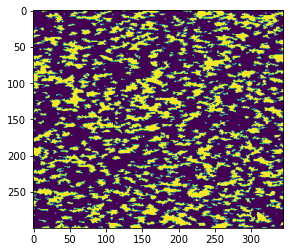

In [33]:
import matplotlib.pyplot as plt
plt.imshow(mat2[0,:,:])
plt.gca().set_aspect(1)

### Convert the whole directory to .npy

In [3]:
import glob

In [8]:
ls -ltr '/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim'

total 2583184
-rw-r--r-- 1 ianpg rknight   8280051 Jun 30 14:20 mps180_0.gslib
-rw-r--r-- 1 ianpg rknight   8280051 Jun 30 14:27 mps180_1.gslib
-rw-r--r-- 1 ianpg rknight   8280051 Jun 30 14:33 mps180_2.gslib
-rw-r--r-- 1 ianpg rknight   8280051 Jun 30 14:39 mps180_3.gslib
-rw-r--r-- 1 ianpg rknight   8280051 Jun 30 14:45 mps180_4.gslib
-rw-r--r-- 1 ianpg rknight   8280051 Jun 30 14:50 mps180_5.gslib
-rw-r--r-- 1 ianpg rknight   8280051 Jun 30 14:57 mps180_6.gslib
-rw-r--r-- 1 ianpg rknight   8280051 Jun 30 15:02 mps180_7.gslib
-rw-r--r-- 1 ianpg rknight   8280051 Jun 30 15:08 mps180_8.gslib
-rw-r--r-- 1 ianpg rknight   8280051 Jun 30 15:14 mps180_9.gslib
-rw-r--r-- 1 ianpg rknight   8280052 Jun 30 15:20 mps180_10.gslib
-rw-r--r-- 1 ianpg rknight   8280052 Jun 30 15:26 mps180_11.gslib
-rw-r--r-- 1 ianpg rknight   8280052 Jun 30 15:32 mps180_12.gslib
-rw-r--r-- 1 ianpg rknight   8280052 Jun 30 15:38 mps180_13.gslib
-rw-r--r-- 1 ianpg rknight   8280052 Jun 30 15:50 mps180_14.gslib
-rw-r-

In [4]:
outputdir_sisim.as_posix()

'/scratch/users/ianpg/SWIlarge/data/lith/sgems/sisim'

In [43]:
import os 
fpaths = glob.glob(outputdir_snesim.joinpath('mps180*.gslib').as_posix())
fpaths.sort(key=os.path.getmtime)

for f in fpaths:
    it = int(f.split('_')[-1].rstrip('.gslib'))
    print(f)
    mat = sgems2modflow(np.loadtxt(f,skiprows=3).astype(np.int))
    np.save(Path(f).parent.joinpath('{}.npy'.format(f.split('.')[0])),mat)

/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_0.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_1.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_2.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_3.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_4.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_5.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_6.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_7.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_8.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_9.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_10.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_11.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_12.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_13.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgem

/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_119.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_120.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_121.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_122.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_123.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_124.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_125.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_126.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_127.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_128.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_129.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_130.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_131.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_132.gslib
/scratch/users/ianpg

/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_237.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_238.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_239.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_240.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_241.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_242.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_243.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_244.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_245.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_246.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_247.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_248.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_249.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_250.gslib
/scratch/users/ianpg

/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_355.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_356.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_357.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_358.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_359.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_360.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_361.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_362.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_363.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_364.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_365.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_366.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_367.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_368.gslib
/scratch/users/ianpg

/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_473.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_474.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_475.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_476.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_477.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_478.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_479.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_480.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_481.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_482.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_483.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_484.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_485.gslib
/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_486.gslib
/scratch/users/ianpg

In [37]:
Path(f).parent.joinpath('{}.npy'.format(f.split('.')[0]))

PosixPath('/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_56.npy')

In [29]:
np.save(Path(f).parent.joinpath('{}.npy'.format(f.split('.')[0])),mat2)

PosixPath('/scratch/users/ianpg/SWIlarge/data/lith/sgems/snesim/mps180_56.npy')

In [ ]:
for i,p in enumerate(outputdir_sisim.iterdir()):
    print(i,p)
    if p.name.startswith('sisim') and p.suffix == '.gslib':
        if p.parent.joinpath('{}.npy'.format(p.name.split('.')[0])).exists():
            print('...exists')
            continue
        mat = sgems2modflow(np.loadtxt(p,skiprows=3).astype(np.int))
        np.save(p.parent.joinpath('{}.npy'.format(p.name.split('.')[0])), mat)

for i,p in enumerate(outputdir_snesim.iterdir()):
    print(i,p)
    if p.name.startswith('mps180') and p.suffix == '.gslib':
        if p.parent.joinpath('{}.npy'.format(p.name.split('.')[0])).exists():
            print('...exists')
            continue
        mat = sgems2modflow(np.loadtxt(p,skiprows=3).astype(np.int))
        np.save(p.parent.joinpath('{}.npy'.format(p.name.split('.')[0])), mat)
